<a href="https://colab.research.google.com/github/tejeshvaish/ModelZoo/blob/master/BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch.utils.data as data
import os
import sys
import random
import numpy as np
import cv2

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [3]:
!ls "/content/gdrive/My Drive"


 brush_hair_test_split1.txt   hmdb_train.npy.zip
'Colab Notebooks'	      model_best.pth.tar
 hmdb51_org.rar		      pytorch_pretrained_bert-0.6.2.tar.gz
 hmdb51.py		      resnext-101-64f-kinetics.pth
 HMDB51.zip		      test_train_splits.rar
 hmdb_test.npy		      UCF101.rar
 hmdb_train.npy


In [4]:
!mkdir project

In [6]:
!pip install rarfile Cython mmcv

     |████████████████████████████████| 317kB 7.9MB/s 
     |████████████████████████████████| 194kB 32.4MB/s 
  Created wheel for mmcv: filename=mmcv-1.3.8-py2.py3-none-any.whl size=451082 sha256=90db50174615a3029bca1a235fff8698f09565bf19101fd5608c8952f490e358
  Stored in directory: /root/.cache/pip/wheels/76/7b/74/1e14a94111277a02048cfa3b6662cc87d153462dcf468ab3e5
Successfully built mmcv


In [7]:
!pip install --upgrade gluoncv


     |████████████████████████████████| 1.3MB 6.5MB/s 


In [8]:
!pip install --upgrade mxnet


     |████████████████████████████████| 46.9MB 67kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [20]:
!python /content/gdrive/MyDrive/hmdb51.py


Streaming output truncated to the last 5000 lines.
[Warning] length inconsistent!Early stop with 85 out of 85 frames
eat/The_Fugitive_4_eat_h_nm_np1_fr_goo_0 done with 85 frames
[Warning] length inconsistent!Early stop with 51 out of 51 frames
hit/KUNG_FU_HUSTLE_hit_f_cm_np1_fr_bad_18 done with 51 frames
[Warning] length inconsistent!Early stop with 124 out of 124 frames
shoot_gun/DefensivePistolShootingTechniques_shoot_gun_f_nm_np1_fr_med_1 done with 124 frames
[Warning] length inconsistent!Early stop with 80 out of 80 frames
smile/my_smile_smile_h_cm_np1_fr_goo_0 done with 80 frames
[Warning] length inconsistent!Early stop with 49 out of 49 frames
hit/TrumanShow_hit_u_cm_np1_ba_bad_35 done with 49 frames
[Warning] length inconsistent!Early stop with 86 out of 86 frames
eat/CharlieAndTheChocolateFactory_eat_h_nm_np1_fr_med_23 done with 86 frames
[Warning] length inconsistent!Early stop with 34 out of 34 frames
hit/When_It_s_Nice_Out_hit_f_cm_np1_le_bad_0 done with 34 frames
[Warning] 

In [25]:
from gluoncv.data import HMDB51
from mxnet.gluon.data import DataLoader
from mxnet.gluon.data.vision import transforms
from gluoncv.data.transforms import video

transform_train = transforms.Compose([
    video.VideoCenterCrop(size=224),
    video.VideoToTensor()
])

# Default location of the data is stored on ~/.mxnet/datasets/hmdb51.
# You need to specify ``setting`` and ``root`` for HMDB51 if you decoded the video frames into a different folder.
test_dataset = HMDB51(train=False, transform=transform_train)
test_data = DataLoader(test_dataset, batch_size=25, shuffle=True)

In [26]:
for x, y in test_data:
    print('Video frame size (batch, extra, channel, height, width):', x.shape)
    print('Video label:', y.shape)
    break

Video frame size (batch, extra, channel, height, width): (25, 1, 3, 224, 224)
Video label: (25,)


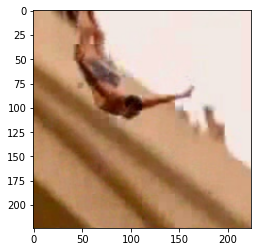

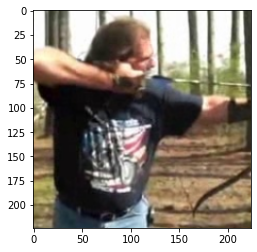

In [28]:
from gluoncv.utils import viz
viz.plot_image(test_dataset[500][0].squeeze().transpose((1,2,0))*255.0)   # dive
viz.plot_image(test_dataset[2500][0].squeeze().transpose((1,2,0))*255.0)  # shoot_bow

In [29]:
import torch
import torch.nn as nn
import torch.hub
import math

In [30]:
class ResNeXt(nn.Module):

    def __init__(self,
                 block,
                 layers,
                 sample_size,
                 sample_duration,
                 shortcut_type='B',
                 cardinality=32,
                 num_classes=400):
        self.inplanes = 64
        super(ResNeXt, self).__init__()
        self.conv1 = nn.Conv3d(
            3,
            64,
            kernel_size=7,
            stride=(1, 2, 2),
            padding=(3, 3, 3),
            bias=False)
        self.bn1 = nn.BatchNorm3d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool3d(kernel_size=(3, 3, 3), stride=2, padding=1)
        self.layer1 = self._make_layer(block, 128, layers[0], shortcut_type,
                                       cardinality)
        self.layer2 = self._make_layer(
            block, 256, layers[1], shortcut_type, cardinality, stride=2)
        self.layer3 = self._make_layer(
            block, 512, layers[2], shortcut_type, cardinality, stride=2)
        self.layer4 = self._make_layer(
            block, 1024, layers[3], shortcut_type, cardinality, stride=2)
        last_duration = int(math.ceil(sample_duration / 16))
        last_size = int(math.ceil(sample_size / 32))
        self.avgpool = nn.AvgPool3d(
            (last_duration, last_size, last_size), stride=1)
        self.fc = nn.Linear(cardinality * 32 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight)
                #m.weight = nn.init.kaiming_normal(m.weight, mode='fan_out')
            elif isinstance(m, nn.BatchNorm3d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self,
                    block,
                    planes,
                    blocks,
                    shortcut_type,
                    cardinality,
                    stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            if shortcut_type == 'A':
                downsample = partial(
                    downsample_basic_block,
                    planes=planes * block.expansion,
                    stride=stride)
            else:
                downsample = nn.Sequential(
                    nn.Conv3d(
                        self.inplanes,
                        planes * block.expansion,
                        kernel_size=1,
                        stride=stride,
                        bias=False), nn.BatchNorm3d(planes * block.expansion))

        layers = []
        layers.append(
            block(self.inplanes, planes, cardinality, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, cardinality))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)

        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [31]:
class ResNeXtBottleneck(nn.Module):
    expansion = 2

    def __init__(self, inplanes, planes, cardinality, stride=1,
                 downsample=None):
        super(ResNeXtBottleneck, self).__init__()
        mid_planes = cardinality * int(planes / 32)
        self.conv1 = nn.Conv3d(inplanes, mid_planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm3d(mid_planes)
        self.conv2 = nn.Conv3d(
            mid_planes,
            mid_planes,
            kernel_size=3,
            stride=stride,
            padding=1,
            groups=cardinality,
            bias=False)
        self.bn2 = nn.BatchNorm3d(mid_planes)
        self.conv3 = nn.Conv3d(
            mid_planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm3d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

In [32]:
def _trained_resnext101(model_path, **kwargs):
    """Constructs a ResNet-101 model.
    """
    model = ResNeXt(ResNeXtBottleneck, [3, 4, 23, 3], **kwargs)
    if model_path=='':
        return model
    params = torch.load(model_path)
    new_dict = {k[7:]: v for k, v in params['state_dict'].items()} 
    model_dict=model.state_dict() 
    model_dict.update(new_dict)
    model.load_state_dict(new_dict)
    return model

In [33]:
class rgb_resneXt3D64f101(nn.Module):
    def __init__(self, num_classes , length, modelPath=''):
        super(rgb_resneXt3D64f101, self).__init__()
        self.num_classes=num_classes
        self.dp = nn.Dropout(p=0.8)
        

        self.features=nn.Sequential(*list(_trained_resnext101(model_path=modelPath, sample_size=112, sample_duration=64).children())[:-1])
        
        self.fc_action = nn.Linear(2048, num_classes)
        for param in self.features.parameters():
            param.requires_grad = True
                
        torch.nn.init.xavier_uniform_(self.fc_action.weight)
        self.fc_action.bias.data.zero_()
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.dp(x)
        x = self.fc_action(x)
        return x

In [34]:
state_dict = torch.load('/content/gdrive/My Drive/resnext-101-64f-kinetics.pth')

In [35]:
print(state_dict.keys)

<built-in method keys of dict object at 0x7f9116438e60>


In [36]:
model = rgb_resneXt3D64f101(num_classes=400, length=64)


In [42]:
path = '/content/gdrive/My Drive/resnext-101-64f-kinetics.pth'

In [39]:
def save_ckp(state, is_best, checkpoint_path, best_model_path):
    """
    state: checkpoint we want to save
    is_best: is this the best checkpoint; min validation loss
    checkpoint_path: path to save checkpoint
    best_model_path: path to save best model
    """
    f_path = checkpoint_path
    # save checkpoint data to the path given, checkpoint_path
    torch.save(state, f_path)
    # if it is a best model, min validation loss
    if is_best:
        best_fpath = best_model_path
        # copy that checkpoint file to best path given, best_model_path
        shutil.copyfile(f_path, best_fpath)

In [40]:
def load_ckp(checkpoint_fpath, model, optimizer):
    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into       
    optimizer: optimizer we defined in previous training
    """
    # load check point
    # initialize state_dict from checkpoint to model
     # --------->>>>> main line
    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])
    # initialize valid_loss_min from checkpoint to valid_loss_min
    valid_loss_min = checkpoint['valid_loss_min']
    # return model, optimizer, epoch value, min validation loss 
    return model, optimizer, checkpoint['epoch'], valid_loss_min.item()

In [43]:
checkpoint = torch.load(path)


In [44]:
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [ ]:
print(model)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import math
from functools import partial
from .NLB.NLBlockND import NLBlockND

from .BERT.bert import  BERT5

__all__ = [ 'rgb_resneXt3D64f101', 'flow_resneXt3D64f101', 
           'rgb_resneXt3D64f101_bert10_FRAB', 'flow_resneXt3D64f101_bert10_FRAB', 
           'rgb_resneXt3D64f101_bert10_FRMB', 'flow_resneXt3D64f101_bert10_FRMB',
           'rgb_resneXt3D64f101_FRMB_adamw', 'rgb_resneXt3D64f101_adamw',
           'rgb_resneXt3D64f101_FRMB_NLB_concatenation', 'rgb_resneXt3D64f101_FRMB_lstm',
           'rgb_resneXt3D64f101_concatenation']


class rgb_resneXt3D64f101(nn.Module):
    def __init__(self, num_classes , length, modelPath=''):
        super(rgb_resneXt3D64f101, self).__init__()
        self.num_classes=num_classes
        self.dp = nn.Dropout(p=0.8)
        

        self.features=nn.Sequential(*list(_trained_resnext101(model_path=modelPath, sample_size=112, sample_duration=64).children())[:-1])
        
        self.fc_action = nn.Linear(2048, num_classes)
        for param in self.features.parameters():
            param.requires_grad = True
                
        torch.nn.init.xavier_uniform_(self.fc_action.weight)
        self.fc_action.bias.data.zero_()
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.dp(x)
        x = self.fc_action(x)
        return x
    

#rgb_resneXt3D64f101_bert10XY2
class rgb_resneXt3D64f101_bert10_FRAB(nn.Module):
    def __init__(self, num_classes , length, modelPath=''):
        super(rgb_resneXt3D64f101_bert10_FRAB, self).__init__()
        self.hidden_size=512
        self.n_layers=1
        self.attn_heads=8
        self.num_classes=num_classes
        self.length=length
        self.dp = nn.Dropout(p=0.8)
        
        self.avgpool = nn.AvgPool3d((1, 4, 4), stride=1)
        self.features=nn.Sequential(*list(_trained_resnext101(model_path=modelPath, sample_size=112, sample_duration=64).children())[:-2])
        
        downsample = nn.Sequential(
            nn.Conv3d(
                2048,
                512,
                kernel_size=1,
                stride=1,
                bias=False), nn.BatchNorm3d(512))

        self.mapper = ResNeXtBottleneck(2048, 256, cardinality = 32, stride = 1, downsample = downsample)

        for m in self.mapper.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight)
                #m.weight = nn.init.kaiming_normal(m.weight, mode='fan_out')
            elif isinstance(m, nn.BatchNorm3d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()      
                
        self.bert = BERT5(self.hidden_size, 4 , hidden=self.hidden_size, n_layers=self.n_layers, attn_heads=self.attn_heads)
        print(sum(p.numel() for p in self.bert.parameters() if p.requires_grad))
        
        self.fc_action = nn.Linear(self.hidden_size, num_classes)
      
        for param in self.features.parameters():
            param.requires_grad = True
  
        torch.nn.init.xavier_uniform_(self.fc_action.weight)
        self.fc_action.bias.data.zero_()
        
    def forward(self, x):
        x = self.features(x)
        x = self.mapper(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), self.hidden_size, 4)
        x = x.transpose(1,2)
        input_vectors=x
        norm = input_vectors.norm(p=2, dim = -1, keepdim=True)
        input_vectors = input_vectors.div(norm)
        output , maskSample = self.bert(x)
        classificationOut = output[:,0,:]
        sequenceOut=output[:,1:,:]
        norm = sequenceOut.norm(p=2, dim = -1, keepdim=True)
        sequenceOut = sequenceOut.div(norm)
        output=self.dp(classificationOut)
        x = self.fc_action(output)
        return x, input_vectors, sequenceOut, maskSample



class rgb_resneXt3D64f101_bert10_FRMB(nn.Module):
    def __init__(self, num_classes , length, modelPath=''):
        super(rgb_resneXt3D64f101_bert10_FRMB, self).__init__()
        self.hidden_size=512
        self.n_layers=1
        self.attn_heads=8
        self.num_classes=num_classes
        self.length=length
        self.dp = nn.Dropout(p=0.8)
        
        self.avgpool = nn.AvgPool3d((1, 4, 4), stride=1)
        self.features=nn.Sequential(*list(_trained_resnext101(model_path=modelPath, sample_size=112, sample_duration=64).children())[:-2])
        
        downsample = nn.Sequential(
            nn.Conv3d(
                2048,
                512,
                kernel_size=1,
                stride=1,
                bias=False), nn.BatchNorm3d(512))

        mapper = ResNeXtBottleneck(2048, 256, cardinality = 32, stride = 1, downsample = downsample)

        for m in mapper.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight)
                #m.weight = nn.init.kaiming_normal(m.weight, mode='fan_out')
            elif isinstance(m, nn.BatchNorm3d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()   
                
        self.features[7][2] = mapper
                
        self.bert = BERT5(self.hidden_size, 4 , hidden=self.hidden_size, n_layers=self.n_layers, attn_heads=self.attn_heads)
        print(sum(p.numel() for p in self.bert.parameters() if p.requires_grad))
        
        self.fc_action = nn.Linear(self.hidden_size, num_classes)
      
        for param in self.features.parameters():
            param.requires_grad = True
  
        torch.nn.init.xavier_uniform_(self.fc_action.weight)
        self.fc_action.bias.data.zero_()
        
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), self.hidden_size, 4)
        x = x.transpose(1,2)
        input_vectors=x
        norm = input_vectors.norm(p=2, dim = -1, keepdim=True)
        input_vectors = input_vectors.div(norm)
        output , maskSample = self.bert(x)
        classificationOut = output[:,0,:]
        sequenceOut=output[:,1:,:]
        norm = sequenceOut.norm(p=2, dim = -1, keepdim=True)
        sequenceOut = sequenceOut.div(norm)
        output=self.dp(classificationOut)
        x = self.fc_action(output)
        return x, input_vectors, sequenceOut, maskSample



class rgb_resneXt3D64f101_concatenation(nn.Module):
    def __init__(self, num_classes , length, modelPath=''):
        super(rgb_resneXt3D64f101_concatenation, self).__init__()
        self.hidden_size=512
        self.n_layers=1
        self.attn_heads=8
        self.num_classes=num_classes
        self.length=length
        self.dp = nn.Dropout(p=0.8)
        
        self.avgpool = nn.AvgPool3d((1, 4, 4), stride=1)
        self.features=nn.Sequential(*list(_trained_resnext101(model_path=modelPath, sample_size=112, sample_duration=64).children())[:-2])
        
        downsample = nn.Sequential(
            nn.Conv3d(
                2048,
                512,
                kernel_size=1,
                stride=1,
                bias=False), nn.BatchNorm3d(512))

        mapper = ResNeXtBottleneck(2048, 256, cardinality = 32, stride = 1, downsample = downsample)

        for m in mapper.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight)
                #m.weight = nn.init.kaiming_normal(m.weight, mode='fan_out')
            elif isinstance(m, nn.BatchNorm3d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()   
                
        self.features[7][2] = mapper
           
        self.linear = nn.Linear(2048, 1550)
        self.fc_action = nn.Linear(1550, num_classes)
      
        for param in self.features.parameters():
            param.requires_grad = True
  
        torch.nn.init.xavier_uniform_(self.fc_action.weight)
        self.fc_action.bias.data.zero_()
        
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), self.hidden_size * 4)
        input_vectors = x
        sequenceOut = x
        maskSample = x
        x = self.dp(x)
        output = self.linear(x)
        x = self.fc_action(output)
        return x, input_vectors, sequenceOut, maskSample

    
    
class rgb_resneXt3D64f101_FRMB_NLB_concatenation(nn.Module):
    def __init__(self, num_classes , length, modelPath=''):
        super(rgb_resneXt3D64f101_FRMB_NLB_concatenation, self).__init__()
        self.hidden_size=512
        self.linear_size = 1000
        self.n_layers=1
        self.attn_heads=8
        self.num_classes=num_classes
        self.length=length
        self.dp = nn.Dropout(p=0.8)
        
        self.avgpool = nn.AvgPool3d((1, 4, 4), stride=1)
        self.features=nn.Sequential(*list(_trained_resnext101(model_path=modelPath, sample_size=112, sample_duration=64).children())[:-2])
        
        downsample = nn.Sequential(
            nn.Conv3d(
                2048,
                self.hidden_size,
                kernel_size=1,
                stride=1,
                bias=False), nn.BatchNorm3d(self.hidden_size))

        mapper = ResNeXtBottleneck(2048, int(self.hidden_size / 2), cardinality = 32, stride = 1, downsample = downsample)

        for m in mapper.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight)
                #m.weight = nn.init.kaiming_normal(m.weight, mode='fan_out')
            elif isinstance(m, nn.BatchNorm3d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()   
                
        self.features[7][2] = mapper
           
        self.NLB = NLBlockND(in_channels = self.hidden_size, inter_channels = self.hidden_size)
        
        self.linear = nn.Linear(self.hidden_size * 4, self.linear_size)
        self.fc_action = nn.Linear(self.linear_size, num_classes)
      
        for param in self.features.parameters():
            param.requires_grad = True
  
        torch.nn.init.xavier_uniform_(self.fc_action.weight)
        self.fc_action.bias.data.zero_()
        
    def forward(self, x):
        x = self.features(x)
        x = self.NLB(x)
        x = self.avgpool(x)
        x = x.view(-1,self.hidden_size * 4)
        input_vectors = x
        sequenceOut = x
        maskSample = x
        x = self.dp(x)
        x = self.linear(x)
        x = self.fc_action(x)
        return x, input_vectors, sequenceOut, maskSample
    
    
    
#rgb_resneXt3D64f101_lstm2
class rgb_resneXt3D64f101_FRMB_lstm(nn.Module):
    def __init__(self, num_classes , length, modelPath=''):
        super(rgb_resneXt3D64f101_FRMB_lstm, self).__init__()
        self.hidden_size = 450
        self.input_size = 512
        self.n_layers=1
        self.attn_heads=8
        self.num_classes=num_classes
        self.length=length
        self.dp = nn.Dropout(p=0.8)
        
        self.avgpool = nn.AvgPool3d((1, 4, 4), stride=1)
        self.features=nn.Sequential(*list(_trained_resnext101(model_path=modelPath, sample_size=112, sample_duration=64).children())[:-2])
        
        downsample = nn.Sequential(
            nn.Conv3d(
                2048,
                self.input_size,
                kernel_size=1,
                stride=1,
                bias=False), nn.BatchNorm3d(self.input_size))

        mapper = ResNeXtBottleneck(2048, int(self.input_size / 2), cardinality = 32, stride = 1, downsample = downsample)

        for m in mapper.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight)
                #m.weight = nn.init.kaiming_normal(m.weight, mode='fan_out')
            elif isinstance(m, nn.BatchNorm3d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()   
                
        self.features[7][2] = mapper
           
        self.lstm=nn.LSTM(input_size=self.input_size, hidden_size=self.hidden_size, num_layers=2, batch_first=True,bidirectional=False)
        self.fc_action = nn.Linear(self.hidden_size, num_classes)
      
        for param in self.features.parameters():
            param.requires_grad = True
  
        torch.nn.init.xavier_uniform_(self.fc_action.weight)
        self.fc_action.bias.data.zero_()
        
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), self.input_size, 4)
        x = x.transpose(1,2)
        output,_=self.lstm(x)
        x= output[:,-1,:]
        input_vectors = x
        sequenceOut = x
        maskSample = x
        x = self.dp(x)
        x = self.fc_action(x)
        return x, input_vectors, sequenceOut, maskSample
    
class rgb_resneXt3D64f101_adamw(nn.Module):
    def __init__(self, num_classes , length, modelPath=''):
        super(rgb_resneXt3D64f101_adamw, self).__init__()
        self.num_classes=num_classes
        self.dp = nn.Dropout(p=0.8)
        

        self.features=nn.Sequential(*list(_trained_resnext101(model_path=modelPath, sample_size=112, sample_duration=64).children())[:-1])
        
        self.fc_action = nn.Linear(2048, num_classes)
        for param in self.features.parameters():
            param.requires_grad = True
                
        torch.nn.init.xavier_uniform_(self.fc_action.weight)
        self.fc_action.bias.data.zero_()
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.dp(x)
        x = self.fc_action(x)
        return x, x, x, x
    
#rgb_resneXt3D64f101_adamw_modified
class rgb_resneXt3D64f101_FRMB_adamw(nn.Module):
    def __init__(self, num_classes , length, modelPath=''):
        super(rgb_resneXt3D64f101_FRMB_adamw, self).__init__()
        self.num_classes=num_classes
        self.dp = nn.Dropout(p=0.8)
        self.hidden_size = 512
        

        self.features=nn.Sequential(*list(_trained_resnext101(model_path=modelPath, sample_size=112, sample_duration=64).children())[:-1])
        
        downsample = nn.Sequential(
            nn.Conv3d(
                2048,
                self.hidden_size,
                kernel_size=1,
                stride=1,
                bias=False), nn.BatchNorm3d(self.hidden_size))

        mapper = ResNeXtBottleneck(2048, int(self.hidden_size / 2), cardinality = 32, stride = 1, downsample = downsample)

        for m in mapper.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight)
                #m.weight = nn.init.kaiming_normal(m.weight, mode='fan_out')
            elif isinstance(m, nn.BatchNorm3d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()   
                
        self.features[7][2] = mapper
        
        self.fc_action = nn.Linear(self.hidden_size, num_classes)
        for param in self.features.parameters():
            param.requires_grad = True
                
        torch.nn.init.xavier_uniform_(self.fc_action.weight)
        self.fc_action.bias.data.zero_()
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.dp(x)
        x = self.fc_action(x)
        return x, x, x, x
    

    

def conv3x3x3(in_planes, out_planes, stride=1):
    # 3x3x3 convolution with padding
    return nn.Conv3d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=1,
        bias=False)


def downsample_basic_block(x, planes, stride):
    out = F.avg_pool3d(x, kernel_size=1, stride=stride)
    zero_pads = torch.Tensor(
        out.size(0), planes - out.size(1), out.size(2), out.size(3),
        out.size(4)).zero_()
    if isinstance(out.data, torch.cuda.FloatTensor):
        zero_pads = zero_pads.cuda()

    out = Variable(torch.cat([out.data, zero_pads], dim=1))

    return out


class ResNeXtBottleneck(nn.Module):
    expansion = 2

    def __init__(self, inplanes, planes, cardinality, stride=1,
                 downsample=None):
        super(ResNeXtBottleneck, self).__init__()
        mid_planes = cardinality * int(planes / 32)
        self.conv1 = nn.Conv3d(inplanes, mid_planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm3d(mid_planes)
        self.conv2 = nn.Conv3d(
            mid_planes,
            mid_planes,
            kernel_size=3,
            stride=stride,
            padding=1,
            groups=cardinality,
            bias=False)
        self.bn2 = nn.BatchNorm3d(mid_planes)
        self.conv3 = nn.Conv3d(
            mid_planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm3d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNeXt(nn.Module):

    def __init__(self,
                 block,
                 layers,
                 sample_size,
                 sample_duration,
                 shortcut_type='B',
                 cardinality=32,
                 num_classes=400):
        self.inplanes = 64
        super(ResNeXt, self).__init__()
        self.conv1 = nn.Conv3d(
            3,
            64,
            kernel_size=7,
            stride=(1, 2, 2),
            padding=(3, 3, 3),
            bias=False)
        self.bn1 = nn.BatchNorm3d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool3d(kernel_size=(3, 3, 3), stride=2, padding=1)
        self.layer1 = self._make_layer(block, 128, layers[0], shortcut_type,
                                       cardinality)
        self.layer2 = self._make_layer(
            block, 256, layers[1], shortcut_type, cardinality, stride=2)
        self.layer3 = self._make_layer(
            block, 512, layers[2], shortcut_type, cardinality, stride=2)
        self.layer4 = self._make_layer(
            block, 1024, layers[3], shortcut_type, cardinality, stride=2)
        last_duration = int(math.ceil(sample_duration / 16))
        last_size = int(math.ceil(sample_size / 32))
        self.avgpool = nn.AvgPool3d(
            (last_duration, last_size, last_size), stride=1)
        self.fc = nn.Linear(cardinality * 32 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight)
                #m.weight = nn.init.kaiming_normal(m.weight, mode='fan_out')
            elif isinstance(m, nn.BatchNorm3d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self,
                    block,
                    planes,
                    blocks,
                    shortcut_type,
                    cardinality,
                    stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            if shortcut_type == 'A':
                downsample = partial(
                    downsample_basic_block,
                    planes=planes * block.expansion,
                    stride=stride)
            else:
                downsample = nn.Sequential(
                    nn.Conv3d(
                        self.inplanes,
                        planes * block.expansion,
                        kernel_size=1,
                        stride=stride,
                        bias=False), nn.BatchNorm3d(planes * block.expansion))

        layers = []
        layers.append(
            block(self.inplanes, planes, cardinality, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, cardinality))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)

        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


def get_fine_tuning_parameters(model, ft_begin_index):
    if ft_begin_index == 0:
        return model.parameters()

    ft_module_names = []
    for i in range(ft_begin_index, 5):
        ft_module_names.append('layer{}'.format(i))
    ft_module_names.append('fc')

    parameters = []
    for k, v in model.named_parameters():
        for ft_module in ft_module_names:
            if ft_module in k:
                parameters.append({'params': v})
                break
        else:
            parameters.append({'params': v, 'lr': 0.0})

    return parameters


def resnext3D50(**kwargs):
    """Constructs a ResNet-50 model.
    """
    model = ResNeXt(ResNeXtBottleneck, [3, 4, 6, 3], **kwargs)
    return model


def resnext3D101(**kwargs):
    """Constructs a ResNet-101 model.
    """
    model = ResNeXt(ResNeXtBottleneck, [3, 4, 23, 3], **kwargs)
    return model

def rgb_mars_resnext3D64f101(num_classes , length, modelPath=''):
    """Constructs a ResNet-101 model.
    """
    model = ResNeXt(ResNeXtBottleneck, [3, 4, 23, 3], sample_size=112, sample_duration=64, num_classes=51)
    return model

def flow_mars_resnext3D64f101(num_classes , length, modelPath=''):
    """Constructs a ResNet-101 model.
    """
    model = ResNeXt(ResNeXtBottleneck, [3, 4, 23, 3], sample_size=112, sample_duration=64, num_classes=51)
    model.conv1 = nn.Conv3d(
        2,
        64,
        kernel_size=7,
        stride=(1, 2, 2),
        padding=(3, 3, 3),
        bias=False)
    return model


def _trained_resnext101(model_path, **kwargs):
    """Constructs a ResNet-101 model.
    """
    model = ResNeXt(ResNeXtBottleneck, [3, 4, 23, 3], **kwargs)
    if model_path=='':
        return model
    params = torch.load(model_path)
    new_dict = {k[7:]: v for k, v in params['state_dict'].items()} 
    model_dict=model.state_dict() 
    model_dict.update(new_dict)
    model.load_state_dict(new_dict)
    return model

def _trained_resnext101_flow(model_path_flow, **kwargs):
    """Constructs a ResNet-101 model.
    """
    model = ResNeXt(ResNeXtBottleneck, [3, 4, 23, 3], **kwargs)
    model.conv1 = nn.Conv3d(
        2,
        64,
        kernel_size=7,
        stride=(1, 2, 2),
        padding=(3, 3, 3),
        bias=False)
    if model_path_flow=='':
        return model
    params = torch.load(model_path_flow)
    new_dict = {k[7:]: v for k, v in params['state_dict'].items()} 
    model_dict=model.state_dict() 
    model_dict.update(new_dict)
    model.load_state_dict(new_dict)
    return model

def resnext3D152(**kwargs):
    """Constructs a ResNet-101 model.
    """
    model = ResNeXt(ResNeXtBottleneck, [3, 8, 36, 3], **kwargs)
    return model
